In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import xarray as xr
import pandas as pd
import metpy.calc as mpcalc
from metpy.units import units
import metpy.constants as littlec



### Notes about units
All temperatures should be in C unless otherwise state 

All air pressure should be in kPa. 1 kPa = 1000 Pa = 10 hPa

Specific humidity should be in kg/kg    

All snow depths should be in m


In [2]:
def BulkRichardson(tg   = 270,
                   ta   = 273,
                   rha  = 60.,
                   u    = 2.0,
                   z    = 28):

    # add units... the inputs must match this
    tg=tg*units("degK")
    ta=ta*units("degK")
    rha=rha*units("percent")
    u=u*units("m/s")

    # compute
    vpg    = mpcalc.saturation_vapor_pressure(tg) # saturation vapor pressure, hPa
    vpasat = mpcalc.saturation_vapor_pressure(ta)
    vpa    = rha*vpasat  # get this from the rh..

    # constants
    z   = z*units("m")       # meters
    atmp = 750* units("hPa") #hpa

    # compute the mixing ratios..
    mr_a = mpcalc.mixing_ratio(vpa, atmp)
    mr_g = mpcalc.mixing_ratio(vpg, atmp)

    # compute the potential temperature
    theta_a = mpcalc.potential_temperature(atmp, ta)
    theta_g = mpcalc.potential_temperature(atmp, tg)

    # compute the virtual pot temp
    theta_va = mpcalc.virtual_potential_temperature(atmp, ta, mr_a)
    theta_vg = mpcalc.virtual_potential_temperature(atmp, tg, mr_g)

    #return Ri(z, theta_a, theta_va, theta_vg, U)
    g=littlec.earth_gravity

    # now this is the bulk richards number...
    return (g/(theta_a)) * z * (theta_va - theta_vg)/u**2


In [3]:
def BulkRichardson_fast(tg, ta, z, u):
    # ta is the atmospher temp in K 
    # tg is the ground or snow themp in K 
    # z is the height in meters
    # u is the wind speed in m/s
    return (9.81 * z * (ta - tg))/(ta*u**2)

#bulk_richardson2(270, 273, 28, 2)
#BulkRichardson(270, 273, 60, 2, 2)

In [4]:
def bulk_cond(rib, z, z0=.002):
    # these are from lapo
    k = 0.4
    b = 12  # this is a stability parameter

    # compute ... this guy 
    chn = k **2 * np.log(z/z0)**(-2)

    # S -- stabiliy parameter 
    S = chn*1/(1 + b * rib)**2

    return S

In [5]:
def rh_from_vp(vp, ta):
    # vp is the partial pressure of water vapor in kpa
    # ta is the air temperature in C
    # rh is the relative humidity in percent

    # bolton eq.; ams glossary
    rh = (vp / (0.61078 * np.exp((17.67 * ta) / (ta + 243.5)))) * 100
    return rh

In [6]:
def vp_from_rh(rh, ta):
    # rh is the relative humidity in percent
    # ta is the air temperature in C
    # vp is the partial pressure of water vapor in kpa
    # bolton eq.; ams glossary
    vp = (rh/100) * 0.61078 * np.exp((17.67 * ta) / (ta + 243.5))
    return vp

In [7]:
def sat_vp_wrt_ice(ti):
    # t is in C
    vp_ice = (1/1000) * np.exp(43.494 - 6545.8/(ti + 278))/(ti + 868)**2 # vp is in kPa
    # # now convert vapor pressure to spec. humidity
    # wa = .622 * vp_ice / (p - vp_ice)
    return vp_ice

In [8]:
def q_from_vp(vp, p):
    # vp is the partial pressure of water vapor in kpa
    # p is the pressure in kpa
    # q is the specific humidity in kg/kg
    # bolton eq.; ams glossary
    q = .622 * vp / (p - vp)
    return q

In [9]:
def rh_from_q(q, ta, p):
    # q is the specific humidity in kg/kg
    # rh is the relative humidity in percent
    # ta is the air temperature in C
    # is atm pressure in kpa
    # bolton eq.; ams glossary
    es = (0.61078 * np.exp((17.67 * ta) / (ta + 243.5))) # saturation vapor pressure   in kpa
    ws = .622 * es / (p - es) # saturation mixing ratio in kg/kg
    qs = ws/(1+ws)            # saturation specific humidity in kg/kg
    rh = q/qs * 100
    return rh

In [10]:
def q_from_rh(p, rh, ta):
    # p is in kpa
    # ta is in C
    es = (0.61078 * np.exp((17.67 * ta) / (ta + 243.5)))

    # q = w / (1 + w)
    # ws = .622 * es/p                             
    ea = es * rh / 100                            # this is the vapor pressure in hpa
    wa = .622 * ea / (p - ea)                     # this is the mixing ratio
    return wa/(wa + 1)                            # this is the specific humidity -- wa is small so it's almost just wa

In [14]:
# clear skies only 
def lw_prata(ta, rh):
    # t is temperature in c
    # vp is vapor pressure in hpa
    # from prata 1996
     
    # compute the vapor pressure
    vp = vp_from_rh(rh, ta) ## this is in kpa 
    vp_hpa = vp * 10        ## this is in hpa
     
    # compute the emissivity
    epsilon = 46.5 * (vp_hpa/(ta+273.15)) # this is hust a term used in the emissivity calculation
    Ea = 1 - (1+epsilon)*np.exp(-np.sqrt(1.2 + 3*epsilon))

    # compute the longwave
    lw = Ea * 5.67e-8 * (ta+273.15)**4
    # return the longwave
    return lw


#### this is the climatalogical lw vs q from Naud et al 2013
# def lw_from_q(q, clear=1):
    # this is from Naud et al 2013...
    # doi:10.1002/jgrd.50644.
    # # q is spec humidity, kg/kg 
    # if clear == 1:
    #     return 152 * (q*1000) **(.29)
    # if clear == 0:
    #     return 219 * (q*1000) **(.19)
    # else:
    #     return None

In [15]:
sebsnc = xr.open_dataset("/Users/william/Documents/projects/Snow_Deposition/all_files_m1_sebs.nc")#.to_pandas()
metnc = xr.open_dataset("/Users/william/Documents/projects/Snow_Deposition/all_met.nc")#.to_pandas()
irtnc = xr.open_dataset("/Users/william/Documents/projects/Snow_Deposition/all_irt.nc")#.to_pandas()

In [16]:
rh = rh_from_vp(metnc.vapor_pressure_mean, metnc.temp_mean).to_pandas()


In [17]:
tsfc=irtnc.sfc_ir_temp.where(irtnc.qc_sfc_ir_temp == 0).to_pandas()

In [18]:
swd = sebsnc.down_short_hemisp.where(sebsnc.qc_down_short_hemisp == 0).to_pandas()
lwd = sebsnc.down_long.where(sebsnc.qc_down_long == 0).to_pandas()
met = metnc[['temp_mean', 'wspd_vec_mean', 'vapor_pressure_mean', 'rh_mean']].to_pandas()

In [19]:
met['swd']  = swd.reindex(method='nearest', index=met.index)
met['lwd']  = lwd.reindex(method='nearest', index=met.index)
met['tsfc'] = tsfc.reindex(method='nearest', index=met.index)
met['rh']   = rh.reindex(method='nearest', index=met.index)

In [20]:
dfsub = met.loc['2023-01-01':'2023-02-15']

In [21]:
dfsub = dfsub.fillna(method='ffill')# inplace=True)
dfsub['tsfc'] = dfsub.tsfc - 273.15


In [32]:
class Constants:
    def __init__(self):
        self.sb = 5.67e-8                             # Stefan-Boltzmann constant
        self.albedo = 0.89                            # Snow albedo
        self.emissivity = 0.98                        # Snow emissivity
        self.density_air = 1.225                      # Air density in kg/m^3
        self.water_dens = 1000                        # density of water kg/m^3
        self.specific_heat_air = 1005                 # Specific heat of air in J/kg-K
        self.cp = 2090.0                              # Specific heat capacity of snow or ice in J/kg/K
        self.cw = 4002.0                              # Specific heat capacity of water (J/kg/C)
        self.pressure = 101325                        # Air pressure in Pa
        self.latent_heat_vapor = 2.5e6                # Latent heat of vaporization of water in J/kg
        self.thermal_conductivity_snow = 0.251        # Thermal conductivity of snow in W/m-K
        self.snow_density = 250                       # Density snow (kg/m^3)

C = Constants()        

In [33]:
# functions to compute heat fluxes

# ground heat flux (where does this equation come from???)
# I'm not sure why there's a '4' in there 
def ghx(C, tg, tsfc):
    G = C.thermal_conductivity_snow * (tg - tsfc) * 4
    return G 

# sensible heat flux
def shx(C, cd, wa, ta, tsfc):
    return C.density_air * C.specific_heat_air * wa * cd * (ta - tsfc) # cd is 1/m
#    return wa * cd * (ta - tsfc) # cd is 1/m

# latent heat flux 
def lhx(C, cd, wa, qa, qsfc):
    return C.density_air * wa * cd * (qa - qsfc) * 2.5e6 # cd is 1/m

# upwelling longwave radiation
def lwup(C, tsfc):
    return C.emissivity*C.sb*(tsfc+273.15)**4

# upwelling shortwave radiation     
def swup(C, swd):
    return C.albedo*swd

In [46]:
# we use this function in the runge-kutta timestepping 
def interp_focings(x, t, h):
    # x is the forcing data
    # t is the integer timestep
    # h is the fractional timestep
    return x[t] + h*(x[t+1] - x[t])

In [36]:
# compute the change in surface layer temperature 

def dT(C, Xt, Tsfc, t, dt, h):
    # C is the non-time dependent parameters
    # Xt is the foring matrix (air temp, ground temp, humidity, wind speed, shortwave, longwave) in that order
    # Tsfc is the temperature at the previous timestep
    # t is the timestep (integer)
    # h is the timestep fraction (float)
    # ----------------------------------

    ### Step 0: 
    dtt = dt + h*dt # this is the timestep in seconds

    ### Step 1: get the forcings for this timestep
    ta  = interp_focings(Xt[0,:], t, h)
    tg  = interp_focings(Xt[1,:], t, h)
    qa  = interp_focings(Xt[2,:], t, h)
    wa  = interp_focings(Xt[3,:], t, h)
    swd = interp_focings(Xt[4,:], t, h)
    lwd = interp_focings(Xt[5,:], t, h)
    rh  = interp_focings(Xt[6,:], t, h)

    # 
#    qa   = q_from_rh(72, rh, ta) # we're saying it's a constant 72kpa...for now 
    qsfc = q_from_rh(72, rh, Tsfc) # we're saying it's a constant 72kpa...for now

    # comput the bulk richardson number
    rib = BulkRichardson_fast(Tsfc + 273.15, ta + 273.15,  2, wa)
    
    # compute the cond
    cd = bulk_cond(rib, z=2, z0=.001) 

    # cap the value of cd
    cd = max(cd, .000001)
    cd = min(cd, .1)

    ### Step 2: compute the heat fluxes     
    # compute the fluxes

    g = ghx(C, tg, Tsfc)    #(tg - tsfc[i-1])*C.thermal_conductivity_snow *4 

    # sensivle heat flux
    sh = shx(C, cd, wa, ta, Tsfc) 
  
    # latent heat flux
    lh = lhx(C, cd, wa, qa, qsfc)

    # compute the lw out 
    netlw = lwd - lwup(C, Tsfc) 

    # compute the sw out
    netsw = swd - swup(C, swd)

    # compute Rnet 
    Rnet = netsw + netlw

    # turb
    Turb = sh + lh + g

    # compute the temperature change 
    height_snow = .05 # meters ... .05 m == 50 mm == 5 cm = ~2in 
    height_ice  = height_snow * C.snow_density / C.water_dens # 1 meter of ice 
    
    # compute change in temp...
    delta_t = (Rnet + Turb) * (1/C.cp) * (1/C.snow_density) * (1/height_ice) * dtt  # dz is in mm .... dtt is timestep in seconds. 

    return delta_t #, g, sh, lh, netsw, netlw 


def runge_kutta(C, Xt, Tsfc, t, dt, h):
    # c is the model parameters 
    # Tsfc is the surface temp at time = t-1
    # t is the time     
   k1 = dT(C, Xt, Tsfc, t, dt, 0) 
   k2 = dT(C, Xt, Tsfc + k1/2, t, dt, h/2.)
   k3 = dT(C, Xt, Tsfc + k1/2, t, dt, h/2.)
   k4 = dT(C, Xt, Tsfc + k3, t, dt, h)
   return Tsfc + (k1 + 2 * k2 + 2 * k3 + k4) * (h/6.0)


In [37]:
def run_model(C, Xt, tsfc_0, dt, h):
  dt = 60   # the data is 60seconds 

  tsfc_arrayx = np.zeros(Xt.shape[1]) + tsfc_0

  for t in range(Xt.shape[1]-1):
      if t == 0:
        pass 
      else:
        tsfc_arrayx[t] = runge_kutta(C, Xt, tsfc_arrayx[t-1], t, dt, h)
  return tsfc_arrayx
        

### run the model 

In [38]:
C = Constants()

# # these are the forcings 
ta  = dfsub.temp_mean           
tg  = np.zeros(len(dfsub)) - 5
qa  = q_from_rh(72, dfsub.rh, dfsub.temp_mean)
wa  = dfsub.wspd_vec_mean       
swd = dfsub.swd  
lwd = dfsub.lwd 
#lwd = lw_prata(dfsub.temp_mean, dfsub.rh)
rh  = dfsub.rh


# this is a matrix of the forcings
Xt = np.array([ta, tg, qa, wa, swd*1.1, lwd, rh]) # this is the series of forcings 

# time stuff 
dt = 60 # the data is 60seconds
h = 1.001

# intitial modlel temp 
tsfc_0 = -10
modt = run_model(C, Xt, tsfc_0, dt, h)

In [39]:
dfsub['modt'] = modt

Text(0, 0.5, 'obs. tsfc')

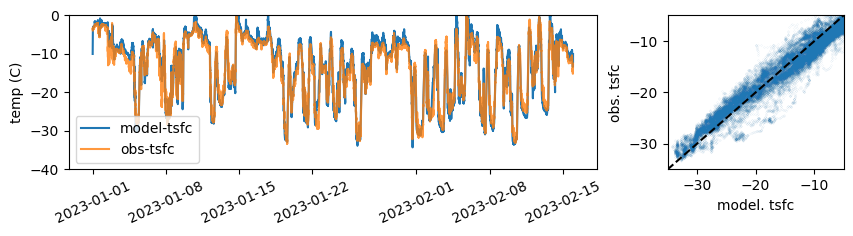

In [43]:
fig,ax=plt.subplots(1,2, figsize=(10,2), gridspec_kw={'width_ratios': [3, 1]})
#dfsub.temp_mean.plot(ax=ax)
ax[0].plot(dfsub.index, dfsub.modt, label='model-tsfc')
ax[0].plot(dfsub.index, dfsub.tsfc, label='obs-tsfc',alpha=.8)
#ax[0].plot(dfsub.index, dfsub.temp_mean, label='air temp')
ax[0].xaxis.set_tick_params(rotation=25)
ax[0].set_ylim(-40, 0)
ax[0].legend()
ax[0].set_ylabel("temp (C)")

ax[1].scatter(dfsub.modt, dfsub.tsfc, s=.001) #plt.legend()
ax[1].set_xlim(-35, -5)
ax[1].set_ylim(-35, -5)
ax[1].plot([-35, -5], [-35, -5], color='k', linestyle='--')
ax[1].set_xlabel("model. tsfc")
ax[1].set_ylabel("obs. tsfc")

<AxesSubplot: xlabel='time'>

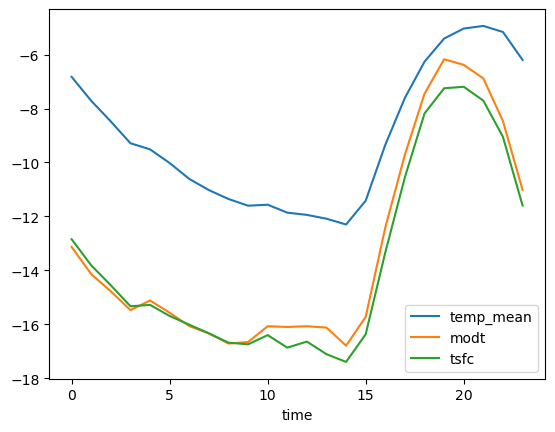

In [44]:
dfsub[['temp_mean', 'modt', 'tsfc']].groupby(dfsub.index.hour).mean().plot()

### Run the model with different coeffcients of thermal heat conductivity 

In [59]:
C = Constants()
C.thermal_conductivity_snow

0.251

In [54]:
C.thermal_conductivity_snow=.151
modt_lowcond = run_model(C, Xt, tsfc_0, dt, h)

C.thermal_conductivity_snow=.551
modt_hicond = run_model(C, Xt, tsfc_0, dt, h)

In [55]:
dfsub['modt_hicond'] = modt_hicond
dfsub['modt_lowcond'] = modt_lowcond

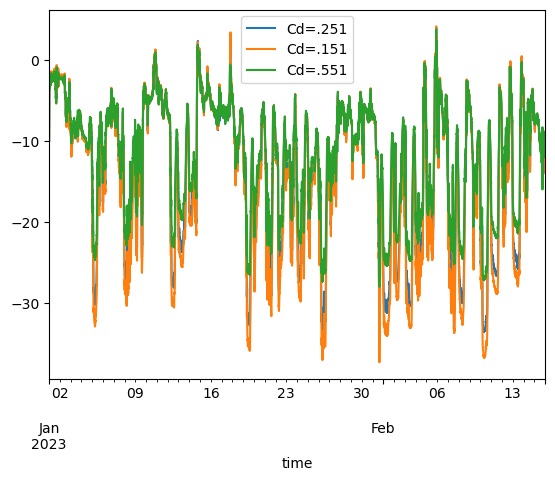

In [62]:
dfsub['modt'].plot(label='Cd=.251')
dfsub['modt_lowcond'].plot(label='Cd=.151')
dfsub['modt_hicond'].plot(label='Cd=.551')
plt.legend()

<AxesSubplot: xlabel='time'>

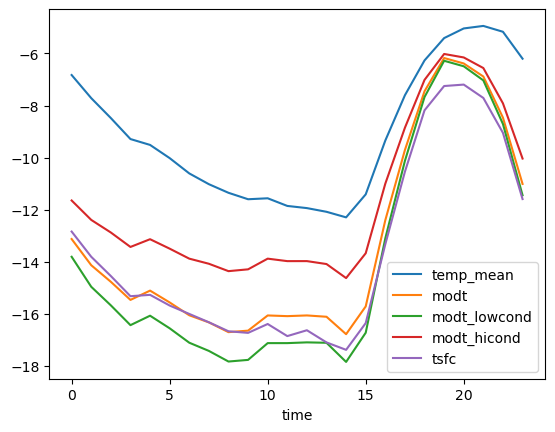

In [64]:
dfsub[['temp_mean', 'modt', 'modt_lowcond', 'modt_hicond', 'tsfc']].groupby(dfsub.index.hour).mean().plot()